### Import dependencies and spark session function

In [9]:
import findspark
findspark.init()

import nltk
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, explode, count, udf
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os
import time

def create_spark_session(app_name="RedditAnalyzer", executor_cores = 3, memory_per_core=3):
    """Create a Spark session connected to the cluster"""
    spark = SparkSession \
        .builder \
        .master("spark://g37-master:7077") \
        .appName(app_name) \
        .config("spark.dynamicAllocation.enabled", True) \
        .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
        .config("spark.shuffle.service.enabled", False) \
        .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
        .config("spark.executor.instances", "2") \
        .config("spark.executor.cores", executor_cores) \
        .config("spark.executor.memory", "6g") \
        .config("spark.driver.memory", "6g") \
        .config("spark.default.parallelism", 18) \
        .config("spark.sql.shuffle.partitions", 18) \
        .config("spark.memory.fraction", 0.8) \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "1g") \
        .getOrCreate()
    
    return spark

### Download stopword collections from NLTK and Spacy

In [10]:
# Download stopwords if not already installed
nltk.download("stopwords")
nltk_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# # Load SpaCy's stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words

In [13]:
# Combine both stopword lists

all_stopwords = nltk_stopwords.union(spacy_stopwords)
common_words = set([
    "like", "one", "would", "know", "really", "get", "go", "even", "thing","think", "want", "see", "dont", "make", "going", "got", "use", "way","something", "still", "actually", "much", "many", "take", "need", "say","better","help", 
    "work", "good", "bad", "also", "people", "time", "day", "come", "back", "im", "ive", "didn't", "started","pretty","went","little","things","feel", "said", "years","cant","told","right","lot","doesnt","thats","didnt", "getting","long","sure" 
])

# Merge with previous stopwords
all_stopwords = all_stopwords.union(common_words)

In [12]:
# Define a UDF to remove stopwords
def remove_stopwords(words):
    return [word for word in words if word not in all_stopwords]

### Main analyisis - Experiment with different cores and dataset size

In [14]:

# Define core and dataset fraction configurations
cores_to_test = [1, 2, 3, 4]
dataset_fractions = [0.25, 0.5, 1.0]

# Store execution times
results = []
# Apply analysis  over each dataset size
for fraction in dataset_fractions:
    # Apply analysis for different numbers of cores
    for cores in cores_to_test:
        spark = create_spark_session(executor_cores=cores)
        start_time = time.time()

        # datset
        df = spark.read.parquet("hdfs:///data/reddit/clean_corpus.parquet")
        subset_df = df.sample(withReplacement=False, fraction=fraction)
    
        
        # Remove all numbers, special characters, and extra spaces
        df_cleaned = subset_df.withColumn("content", regexp_replace(col("content"), "[^a-zA-Z\s]", "")).withColumn("content", regexp_replace(col("content"), "\s+", " "))  # Remove extra spaces
        
        
        # Tokenize words (split text into words)
        tokenizer = Tokenizer(inputCol="content", outputCol="words")
        df_tokenized = tokenizer.transform(df_cleaned)
        
        # Register UDF in Spark
        remove_stopwords_udf = udf(remove_stopwords, ArrayType(StringType()))
        
        # Apply stopword removal on tokenized words
        df_filtered = df_tokenized.withColumn("filtered_words", remove_stopwords_udf(df_tokenized["words"]))
        
        # Explode words column to count occurrences
        df_words = df_filtered.select(explode(col("filtered_words")).alias("word"))
        df_word_count = df_words.groupBy("word").agg(count("word").alias("count"))
        
        # Sort by frequency to find the most common topics
        df_sorted_words = df_word_count.orderBy(col("count").desc())
        
        # Convert Spark DataFrame to Pandas (limit to top 10 words for visualization)
        top_words_pd = df_sorted_words.limit(10).toPandas()
        
        # compute execution time
        end_time = time.time()
        execution_time = end_time - start_time
        results.append((cores, fraction, execution_time))
        spark.stop()



### Plot graph for execution time vs cores for different dataset sizes

    Cores  Dataset Fraction  Execution Time (s)
0       1              0.25          321.808309
1       2              0.25          185.223739
2       3              0.25          168.118449
3       4              0.25          182.090227
4       1              0.50          412.982068
5       2              0.50          333.174563
6       3              0.50          328.705122
7       4              0.50          385.351830
8       1              1.00          803.606364
9       2              1.00          658.743883
10      3              1.00          661.755177
11      4              1.00          858.085631


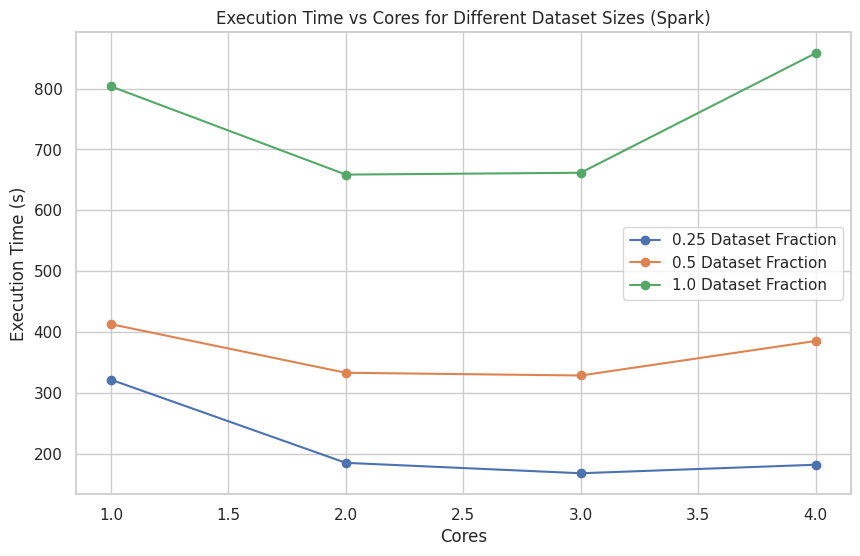

In [15]:
df_results = pd.DataFrame(results, columns=["Cores", "Dataset Fraction", "Execution Time (s)"])
print(df_results)

# Plot execution times
plt.figure(figsize=(10, 6))

# Plot line for each dataset fraction
for fraction in df_results["Dataset Fraction"].unique():
    subset = df_results[df_results["Dataset Fraction"] == fraction]
    plt.plot(subset["Cores"], subset["Execution Time (s)"], 
             marker='o', 
             label=f"{fraction} Dataset Fraction")

# Add labels and title
plt.xlabel("Cores")
plt.ylabel("Execution Time (s)")
plt.title("Execution Time vs Cores for Different Dataset Sizes (Spark)")

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Plot graph for top 10 most common topic words in Reddit discussions

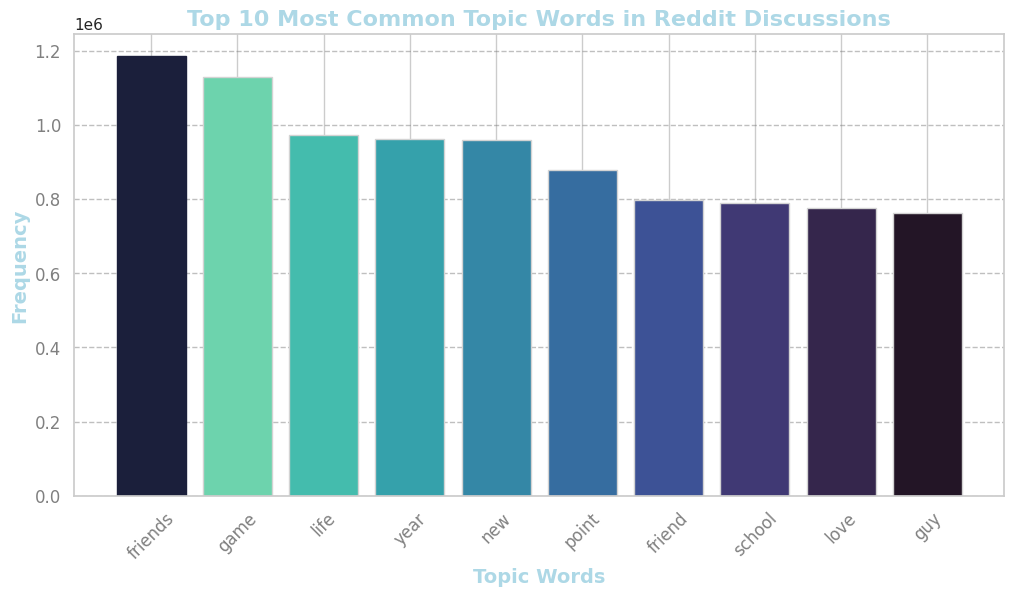

In [16]:
# Set modern theme
sns.set_theme(style="whitegrid")

# Define a dark color palette (Deeper tones from Viridis)
colors = sns.color_palette("mako_r", len(top_words_pd))  # Using "mako" reversed for a dark theme

# Create figure
plt.figure(figsize=(12, 6))
bars = plt.bar(top_words_pd["word"], top_words_pd["count"], color=colors, edgecolor="lightgray")  # Light edge for contrast

# Rotate x labels for better visibility
plt.xticks(rotation=45, fontsize=12, color="gray")
plt.yticks(fontsize=12, color="gray")

# Add labels & title with custom styling
plt.xlabel("Topic Words", fontsize=14, fontweight="bold", color="lightblue")
plt.ylabel("Frequency", fontsize=14, fontweight="bold", color="lightblue")
plt.title("Top 10 Most Common Topic Words in Reddit Discussions", fontsize=16, fontweight="bold", color="lightblue")

# Add grid lines in a subtle dark gray
plt.grid(axis="y", linestyle="--", alpha=0.5, color="gray")

# Highlight the highest bar in an even darker shade for emphasis
bars[0].set_color("#1b1f3b")  # Deep Navy Blue (almost black)

# Show plot
plt.show()


### After this...
1. Commit and push your changes (see `README`)
2. Run `./stop_cluster.sh` on the VM to shut down Spark clusters, HDFS, and Jupyter.